In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from astropy.stats import LombScargle

from maelstrom.maelstrom import Maelstrom
from maelstrom.model import InterpMaelstrom
from maelstrom.estimator import estimate_frequencies

/Users/dforeman/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Let's measure the time delay curve using a linear spline. First, load the data:

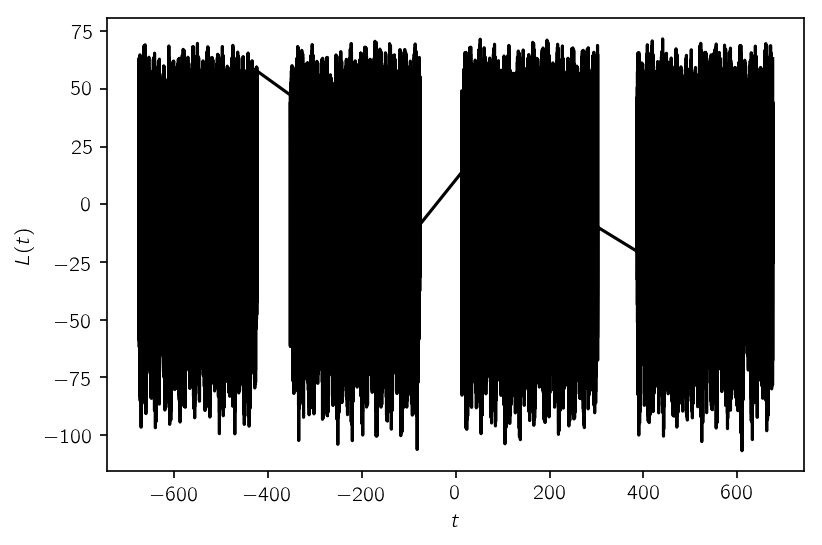

In [18]:
kicid = 11754974
data = np.loadtxt("data/kic{0}_lc.txt".format(kicid))
fulltimes = data[:, 0] # days
tmid = 0.5*(fulltimes[0] + fulltimes[-1])
times = fulltimes - tmid
dmmags = data[:, 1] * 1000. # mmags

metadata = np.loadtxt("data/kic{0}_metadata_more.csv".format(kicid), delimiter=",", skiprows=1)
nu_arr = metadata[::6]

plt.plot(times, dmmags, "k")
plt.xlabel(r"$t$")
plt.ylabel(r"$L(t)$");

In [52]:
nnu = 8
nu_arr

array([ 16.34474,  21.39898,  20.9074 ,  20.94355,  22.6602 ,   4.5627 ,
         4.5988 ,   5.0542 ,  11.2905 ,  11.7459 ,  11.7821 ,  17.117  ,
         6.3155 ,   1.2612 ,   0.4916 ,  15.2743 ,  19.7835 ,  20.0186 ,
        20.2424 ,  20.4487 ,  20.4552 ,  26.4532 ,  32.6895 ,  37.2521 ,
        37.2883 ,  37.7437 ,  39.0049 ,  41.8509 ,  42.3064 ,  42.798  ,
        49.0342 ,  53.5969 ,  53.633  ,  54.0885 ,  59.1427 ,  65.379  ])

Now, let's set up the model. We'll use 1000 control points in the spline and we'll start with them randomly distributed with a standard deviation of 1e-5.

In [35]:
N = 1000
model = InterpMaelstrom(times, dmmags, nu_arr[:nnu], log_sigma2=0.0,
                        interp_x=np.linspace(times.min(), times.max(), N),
                        interp_y=1e-5*np.random.randn(N))

Here's the initial time delay curve:

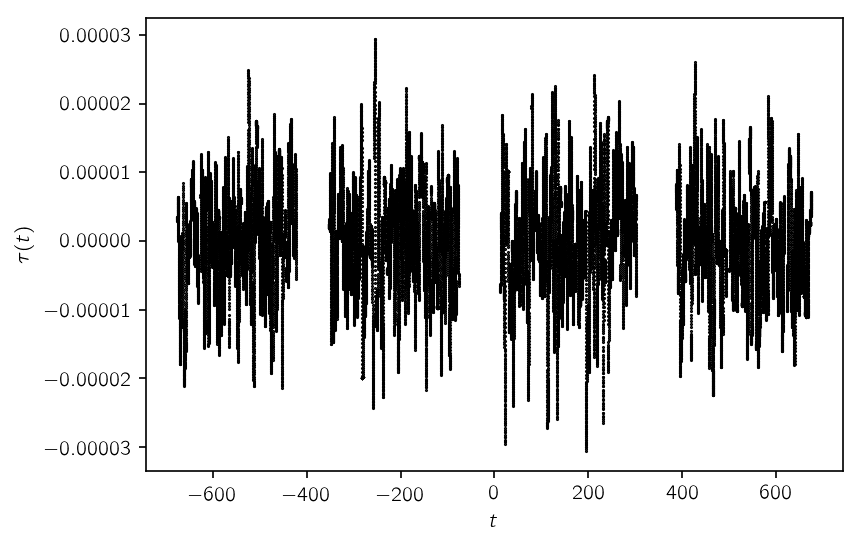

In [36]:
plt.plot(times, model.run(model.tau)[:, 0], ".k", ms=1)
plt.ylabel(r"$\tau(t)$")
plt.xlabel("$t$");

Now let's optimize the frequency vector and the noise variance:

In [37]:
model.optimize([model.log_sigma2, model.nu])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 293243.508566
  Number of iterations: 85
  Number of functions evaluations: 106


Then we'll fit for the time delay curve at a set of 1000 control points as defined above. We're using a gradient optimizer that tends to be better if you have a lot of parameters (it was designed for neural networks).

In [38]:
opt = tf.train.AdamOptimizer().minimize(
    model.chi2, var_list=[model.interp_y, model.log_sigma2])
model.run(tf.global_variables_initializer())

bar = tqdm.trange(1000)
for i in bar:
    chi2, _ = model.run([model.chi2, opt])
    bar.set_postfix(chi2="{0:.0f}".format(chi2))

100%|██████████| 1000/1000 [00:33<00:00, 29.82it/s, chi2=440605]


Here's the new time delay curve:

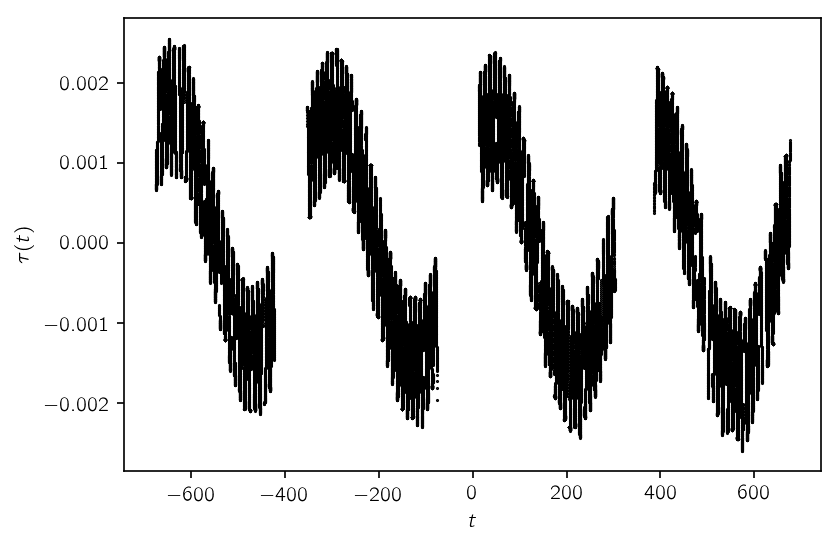

In [39]:
plt.plot(times, model.run(model.tau)[:, 0], ".k", ms=1)
plt.ylabel(r"$\tau(t)$")
plt.xlabel("$t$");

That looks interesting! Let's do one more round of optimization to make sure that we're converged to something.

In [40]:
bar = tqdm.trange(1000)
for i in bar:
    chi2, _ = model.run([model.chi2, opt])
    bar.set_postfix(chi2="{0:.0f}".format(chi2))

100%|██████████| 1000/1000 [00:37<00:00, 26.42it/s, chi2=293904]


And here's the new time delay curve:

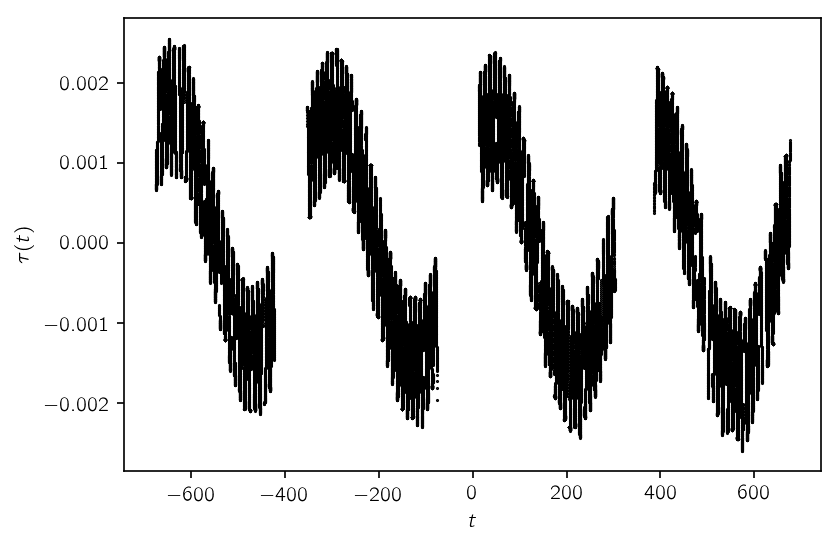

In [41]:
plt.plot(times, model.run(model.tau)[:, 0], ".k", ms=1)
plt.ylabel(r"$\tau(t)$")
plt.xlabel("$t$");

Cool. What if we zoom in?

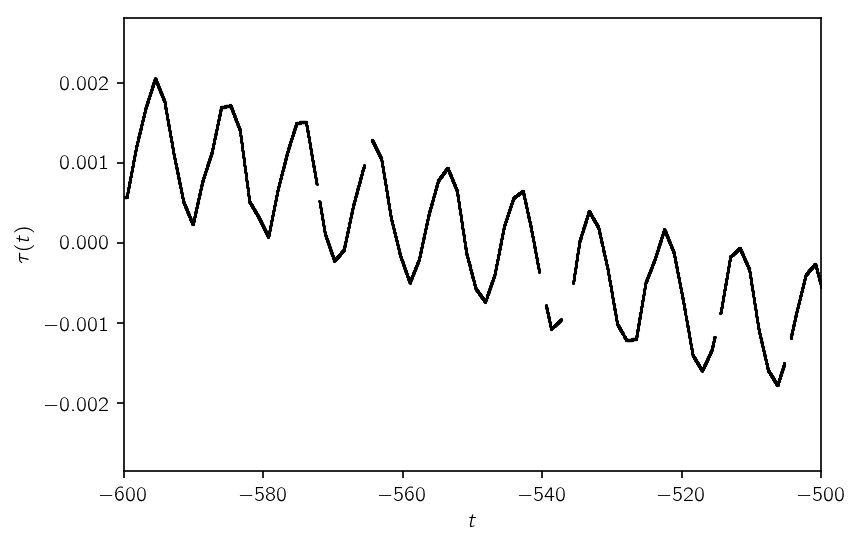

In [42]:
plt.plot(times, model.run(model.tau)[:, 0], ".k", ms=1)
plt.xlim(-600, -500)
plt.ylabel(r"$\tau(t)$")
plt.xlabel("$t$");

That looks pretty legit. What about the PSD of the time delay curve?

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.004405
  Number of iterations: 5
  Number of functions evaluations: 13
[ 342.2933652    10.49858426]


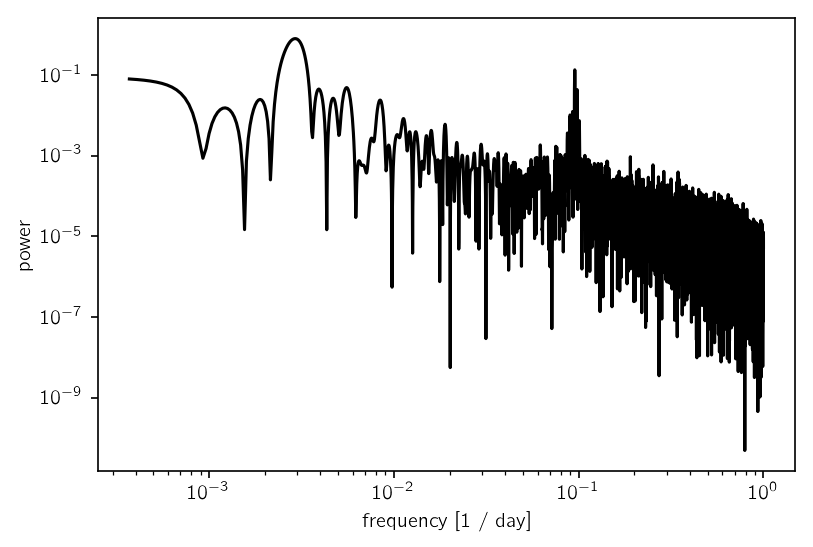

In [43]:
x, y = model.run([model.time, model.psi])
df = 0.5 / (times.max() - times.min())
freq = np.arange(df, 1.0, 0.1*df)
power = LombScargle(x, y).power(freq)

peaks = estimate_frequencies(x, y, max_peaks=2)
print(1.0 / peaks)

plt.loglog(freq, power, "k")
plt.ylabel("power")
plt.xlabel("frequency [1 / day]");

This has signal at 346 days as previously reported, and a new signal at 10.5 days.

Now let's fit for the primary Keplerian orbit as we were doing earlier this week:

In [53]:
kep_model_1 = Maelstrom(times, dmmags, nu_arr[:nnu])
kep_model_1.init_from_orbit(period=1.0 / peaks[0], lighttime=np.std(y), tref=0.0)
kep_model_1.pin_lighttime_values()
for i in range(3):
    kep_model_1.optimize([kep_model_1.log_sigma2])
    kep_model_1.optimize([kep_model_1.lighttime, kep_model_1.tref])
    kep_model_1.optimize([kep_model_1.period, kep_model_1.lighttime, kep_model_1.tref])
    kep_model_1.optimize([kep_model_1.period, kep_model_1.lighttime, kep_model_1.tref,
                          kep_model_1.eccen_param, kep_model_1.varpi])
    kep_model_1.optimize([kep_model_1.nu])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 276903.817539
  Number of iterations: 11
  Number of functions evaluations: 12
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 243621.413776
  Number of iterations: 4
  Number of functions evaluations: 9
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 239449.601734
  Number of iterations: 8
  Number of functions evaluations: 14
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 239449.601734
  Number of iterations: 1
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 238564.39

Then overplot the time delay curve on the one from before. Looks about right modulo some "slope" in the spline version.

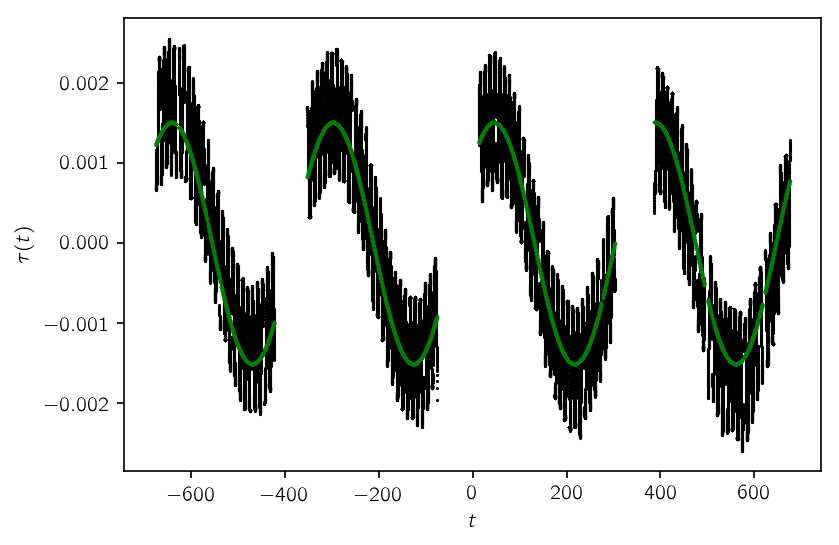

In [54]:
plt.plot(times, model.run(model.tau)[:, 0], ".k", ms=1)
plt.plot(times, kep_model_1.run(kep_model_1.tau)[:, 0], ".g", ms=1)
plt.ylabel(r"$\tau(t)$")
plt.xlabel("$t$");

Now, let's subtract out the primary time delay and fit for the second signal.

In [55]:
tau1 = kep_model_1.run(kep_model_1.tau)[:, 0]
kep_model_2 = Maelstrom(times - tau1, dmmags, nu_arr[:nnu])
kep_model_2.init_from_orbit(period=1.0 / peaks[1], lighttime=0.5*np.std(y), tref=0.0)
kep_model_2.pin_lighttime_values()
for i in range(3):
    kep_model_2.optimize([kep_model_2.log_sigma2])
    kep_model_2.optimize([kep_model_2.lighttime, kep_model_2.tref])
    kep_model_2.optimize([kep_model_2.period, kep_model_2.lighttime, kep_model_2.tref])
    kep_model_2.optimize([kep_model_2.period, kep_model_2.lighttime, kep_model_2.tref,
                          kep_model_2.eccen_param, kep_model_2.varpi, kep_model_2.tref])
    kep_model_2.optimize([kep_model_2.nu])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 227896.666753
  Number of iterations: 10
  Number of functions evaluations: 11
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 206244.000827
  Number of iterations: 21
  Number of functions evaluations: 28
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 206243.031005
  Number of iterations: 2
  Number of functions evaluations: 6
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 206243.030979
  Number of iterations: 1
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 203861.1

This time, let's plot the time delay curve folded on itself. (Note: I've subtracted the first Keplerian fit out of the spline results).

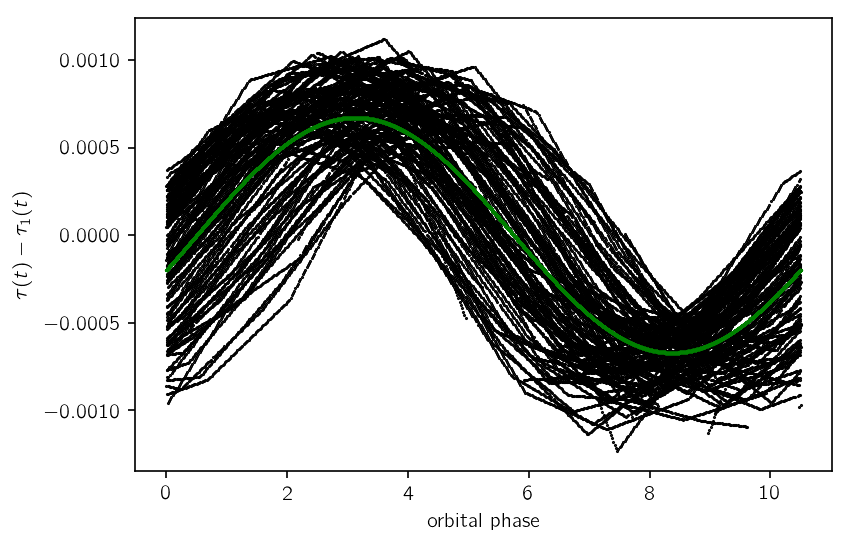

In [58]:
period = kep_model_2.run(kep_model_2.period)
plt.plot(times % period, model.run(model.tau)[:, 0] - tau1, ".k", ms=1)
plt.plot(times % period, kep_model_2.run(kep_model_2.tau)[:, 0], ".g", ms=1)
plt.ylabel(r"$\tau(t) - \tau_1(t)$")
plt.xlabel("orbital phase");

Dashy cray. It looks like this orbit has the following parameters:

In [57]:
print("period: {0:.5f} day".format(kep_model_2.run(kep_model_2.period)))
print("a1 sin(i) / c: {0:.5f} sec".format(86400.0 * np.abs(kep_model_2.run(kep_model_2.lighttime[0]))))

period: 10.49870 day
a1 sin(i) / c: 58.07424 sec
